<a href="https://colab.research.google.com/github/AliAkbarBadri/topics-for-types/blob/main/types.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
! pip -q install laserembeddings
! python -m laserembeddings download-models
! pip -q install transformers

     |████████████████████████████████| 51kB 3.3MB/s 
     |████████████████████████████████| 860kB 8.7MB/s 

✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fcodes    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fvocab    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/bilstm.93langs.2018-12-26.pt    

✨ You're all set!
     |████████████████████████████████| 1.3MB 3.4MB/s 
     |████████████████████████████████| 1.1MB 22.2MB/s 
     |████████████████████████████████| 2.9MB 35.7MB/s 


In [9]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, AutoTokenizer, AutoModel
from laserembeddings import Laser
from __future__ import unicode_literals

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Word2Vec

In [17]:
df_types_lstm = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types.csv")
df_types_lstm.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,تفاوت ترمز عقب دیسکی و کاسه ای چیست؟,0,0,0,0,1,1,0,0,0,1,0,0
1,آیا ترمز ضدقفل ABS در همه چرخ ها عمل می کند؟,0,1,0,0,0,1,0,0,0,1,0,0
2,چرا باوجود نصب بودن ترمز ABS بر روی خودرو، ترم...,0,0,0,0,0,1,1,0,0,1,0,0
3,چرا با وجود نصب بودن Airbag بر روی خودرو، در ه...,0,0,0,0,0,1,1,0,0,1,0,0
4,کلاس های مختلف خودرو چگونه شناسایی می شوند؟,0,0,0,0,1,0,0,0,1,1,0,0


In [18]:
X = df_types_lstm[df_types_lstm.columns[0]].values
Y = df_types_lstm[df_types_lstm.columns[1:]].values

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

In [20]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [21]:
vocab_size, X_train.shape, y_train.shape, X_test.shape, y_test.shape

(8612, (2181, 200), (2181, 12), (243, 200), (243, 12))

In [22]:
embeddings_dictionary = dict()

glove_file = open('drive/My Drive/nlp/similarity/embeddings/twitt_wiki_ham_blog.fa.text.100.vec', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(maxlen,)),
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim = 100, 
                            weights=[embedding_matrix],
                            trainable=False, name='Embedding_Layer'),
    tf.keras.layers.LSTM(200,
                        # return_sequences=True,
                        # stateful=True,
                        recurrent_initializer='glorot_uniform',
                        name='LSTM_Layer'),
    tf.keras.layers.Dense(12, activation='sigmoid', name='Dense_Layer')
  ], name='LSTM_Model')
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['acc'])
print(model.summary())
print()
print(model.layers[0].weights)

Model: "LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_Layer (Embedding)  (None, 200, 100)          861200    
_________________________________________________________________
LSTM_Layer (LSTM)            (None, 200)               240800    
_________________________________________________________________
Dense_Layer (Dense)          (None, 12)                2412      
Total params: 1,104,412
Trainable params: 243,212
Non-trainable params: 861,200
_________________________________________________________________
None

[<tf.Variable 'Embedding_Layer/embeddings:0' shape=(8612, 100) dtype=float32, numpy=
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [-2.222517, -0.428454, -1.253941, ...,  0.361452,  1.804778,
        -0.216301],
       [-0.132566, -4.901635, -1.319971, ...,  0.09917 ,  4.036689,
        -0.957019],
       ...,
     

In [24]:
history = model.fit(X_train, y_train, batch_size=32, epochs=15, verbose=1, validation_split=0.2)

Epoch 1/15
55/55 [==============================] - 2s 27ms/step - loss: 0.3126 - acc: 0.4828 - val_loss: 0.2911 - val_acc: 0.4920
Epoch 2/15
55/55 [==============================] - 1s 20ms/step - loss: 0.2914 - acc: 0.4931 - val_loss: 0.2928 - val_acc: 0.4920
Epoch 3/15
55/55 [==============================] - 1s 20ms/step - loss: 0.2915 - acc: 0.4931 - val_loss: 0.2913 - val_acc: 0.4920
Epoch 4/15
55/55 [==============================] - 1s 20ms/step - loss: 0.2902 - acc: 0.4931 - val_loss: 0.2891 - val_acc: 0.4920
Epoch 5/15
55/55 [==============================] - 1s 20ms/step - loss: 0.2895 - acc: 0.4931 - val_loss: 0.2885 - val_acc: 0.4920
Epoch 6/15
55/55 [==============================] - 1s 20ms/step - loss: 0.2904 - acc: 0.4931 - val_loss: 0.2920 - val_acc: 0.4920
Epoch 7/15
55/55 [==============================] - 1s 20ms/step - loss: 0.2891 - acc: 0.4931 - val_loss: 0.2893 - val_acc: 0.4920
Epoch 8/15
55/55 [==============================] - 1s 20ms/step - loss: 0.2891 - a

In [25]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

8/8 [==============================] - 0s 7ms/step - loss: 0.3023 - acc: 0.4403
Test Score: 0.3022744953632355
Test Accuracy: 0.4403292238712311


# LASER

In [26]:
laser = Laser()

In [27]:
df_types_laser = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types.csv")
df_types_laser.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,تفاوت ترمز عقب دیسکی و کاسه ای چیست؟,0,0,0,0,1,1,0,0,0,1,0,0
1,آیا ترمز ضدقفل ABS در همه چرخ ها عمل می کند؟,0,1,0,0,0,1,0,0,0,1,0,0
2,چرا باوجود نصب بودن ترمز ABS بر روی خودرو، ترم...,0,0,0,0,0,1,1,0,0,1,0,0
3,چرا با وجود نصب بودن Airbag بر روی خودرو، در ه...,0,0,0,0,0,1,1,0,0,1,0,0
4,کلاس های مختلف خودرو چگونه شناسایی می شوند؟,0,0,0,0,1,0,0,0,1,1,0,0


In [28]:
df_types_laser['sentence'] = df_types_laser['sentence'].apply(lambda sent: laser.embed_sentences(sent, lang='fa')[0])
df_types_laser.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,"[0.020942228, -8.114154e-05, -0.0009854112, 0....",0,0,0,0,1,1,0,0,0,1,0,0
1,"[0.00867996, 0.0027223467, -0.00016234924, 0.0...",0,1,0,0,0,1,0,0,0,1,0,0
2,"[0.011158594, 0.018385716, -8.350732e-05, 0.01...",0,0,0,0,0,1,1,0,0,1,0,0
3,"[0.009575151, 0.01364643, 7.700209e-05, 0.0117...",0,0,0,0,0,1,1,0,0,1,0,0
4,"[0.027029106, 0.002408459, 0.00048337242, 0.00...",0,0,0,0,1,0,0,0,1,1,0,0


In [50]:
X = np.array(df_types_laser[df_types_laser.columns[0]])
X = np.vstack(X)

Y = df_types_laser[df_types_laser.columns[1:]].values

X.shape, Y.shape

((2424, 1024), (2424, 12))

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

In [52]:
len(X_train),len(X_test),len(y_train),len(y_test)

(2181, 243, 2181, 243)

In [63]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X[0].shape, name='input_layer'),
    tf.keras.layers.Dense(100, activation='relu', name='Dense_Layer'),
    tf.keras.layers.Dense(12, activation='sigmoid', name='Dense_Layer2'),
  ], name='LASER_Model')

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
print(model.summary())

Model: "LASER_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer (Dense)          (None, 100)               102500    
_________________________________________________________________
Dense_Layer2 (Dense)         (None, 12)                1212      
Total params: 103,712
Trainable params: 103,712
Non-trainable params: 0
_________________________________________________________________
None


In [64]:
history = model.fit(X_train, y_train, batch_size=8, epochs=30, verbose=1, validation_split=0.2)

Epoch 1/30
218/218 [==============================] - 1s 3ms/step - loss: 0.3251 - acc: 0.4719 - val_loss: 0.2679 - val_acc: 0.4920
Epoch 2/30
218/218 [==============================] - 1s 3ms/step - loss: 0.2620 - acc: 0.4507 - val_loss: 0.2453 - val_acc: 0.4645
Epoch 3/30
218/218 [==============================] - 1s 2ms/step - loss: 0.2404 - acc: 0.4817 - val_loss: 0.2273 - val_acc: 0.5263
Epoch 4/30
218/218 [==============================] - 1s 3ms/step - loss: 0.2230 - acc: 0.5935 - val_loss: 0.2131 - val_acc: 0.6430
Epoch 5/30
218/218 [==============================] - 1s 3ms/step - loss: 0.2092 - acc: 0.6554 - val_loss: 0.2024 - val_acc: 0.6499
Epoch 6/30
218/218 [==============================] - 1s 3ms/step - loss: 0.1982 - acc: 0.6852 - val_loss: 0.1961 - val_acc: 0.6911
Epoch 7/30
218/218 [==============================] - 1s 3ms/step - loss: 0.1888 - acc: 0.7001 - val_loss: 0.1889 - val_acc: 0.6979
Epoch 8/30
218/218 [==============================] - 1s 2ms/step - loss: 0.

In [65]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

8/8 [==============================] - 0s 2ms/step - loss: 0.1761 - acc: 0.7531
Test Score: 0.1761440485715866
Test Accuracy: 0.7530864477157593


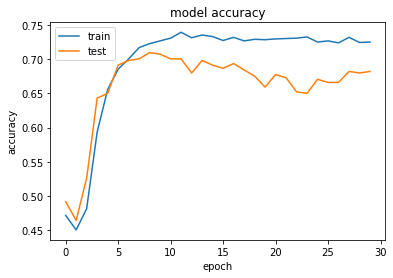

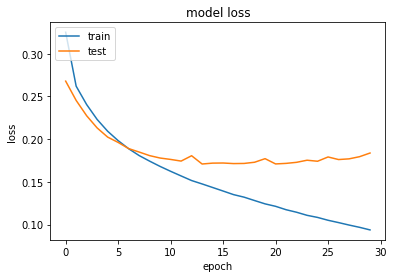

In [66]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# BERT

In [36]:
config = AutoConfig.from_pretrained("m3hrdadfi/albert-fa-base-v2")
tokenizer = AutoTokenizer.from_pretrained("m3hrdadfi/albert-fa-base-v2")
bert_model = AutoModel.from_pretrained("m3hrdadfi/albert-fa-base-v2")

In [37]:
def get_embedding(sent):
    input_sentence = torch.tensor(tokenizer.encode(sent, max_length = 500)).unsqueeze(0)
    out = bert_model(input_sentence)
    embeddings_of_last_layer = out[0]
    cls_embeddings = embeddings_of_last_layer[0][0]
    cls_embeddings = cls_embeddings.detach().numpy()
    return cls_embeddings

In [ ]:
# df_types_bert = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types.csv")

In [ ]:
# df_types_bert['sentence'] = df_types_bert['sentence'].apply(lambda sent: get_embedding(sent))
# df_types_bert.to_csv("/content/drive/My Drive/topics-for-types/df_types_bert.csv", index=False)
# df_types_bert.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,"[-0.5841074, -0.017078003, -0.32405344, -0.645...",0,0,0,0,1,1,0,0,0,1,0,0
1,"[-0.31120673, -0.0050979797, 0.10509731, -0.36...",0,1,0,0,0,1,0,0,0,1,0,0
2,"[0.05544515, -0.23301096, 0.12021764, -0.33959...",0,0,0,0,0,1,1,0,0,1,0,0
3,"[0.37881416, -0.1909234, 0.16427912, -0.383240...",0,0,0,0,0,1,1,0,0,1,0,0
4,"[-0.46968994, -0.2401005, 0.20189604, -0.20498...",0,0,0,0,1,0,0,0,1,1,0,0


In [38]:
df_types_bert = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types_bert.csv")
df_types_bert['sentence'] = df_types_bert['sentence'].apply(lambda x: 
                           np.fromstring(
                               x.replace('\n','')
                                .replace('[','')
                                .replace(']','')
                                .replace('  ',' '), sep=' '))
df_types_bert.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,"[-0.584107399, -0.0170780029, -0.324053437, -0...",0,0,0,0,1,1,0,0,0,1,0,0
1,"[-0.311206728, -0.00509797968, 0.105097309, -0...",0,1,0,0,0,1,0,0,0,1,0,0
2,"[0.0554451495, -0.233010963, 0.120217644, -0.3...",0,0,0,0,0,1,1,0,0,1,0,0
3,"[0.378814161, -0.190923393, 0.164279118, -0.38...",0,0,0,0,0,1,1,0,0,1,0,0
4,"[-0.469689935, -0.240100503, 0.201896042, -0.2...",0,0,0,0,1,0,0,0,1,1,0,0


In [67]:
X = np.array(df_types_bert[df_types_bert.columns[0]])
X = np.vstack(X)

Y = df_types_bert[df_types_bert.columns[1:]].values

X.shape, Y.shape

((2424, 768), (2424, 12))

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

In [69]:
len(X_train),len(X_test),len(y_train),len(y_test)

(1939, 485, 1939, 485)

In [80]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X[0].shape, name='input_layer'),
    tf.keras.layers.Dense(100, activation='relu', name='Dense_Layer',
                          activity_regularizer=tf.keras.regularizers.l2()),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout"),
    # tf.keras.layers.Dense(100, activation='relu', name='Dense_Layer2',
                          # activity_regularizer=tf.keras.regularizers.l2()),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout2"),
    tf.keras.layers.Dense(12, activation='sigmoid', name='Dense_Layer3'),

  ], name='BERT_MODEL')

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "BERT_MODEL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer (Dense)          (None, 100)               76900     
_________________________________________________________________
Dense_Layer3 (Dense)         (None, 12)                1212      
Total params: 78,112
Trainable params: 78,112
Non-trainable params: 0
_________________________________________________________________
None


In [81]:
history = model.fit(X_train, y_train, batch_size=8, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
194/194 [==============================] - 1s 4ms/step - loss: 0.4324 - acc: 0.5319 - val_loss: 0.3657 - val_acc: 0.5747
Epoch 2/20
194/194 [==============================] - 1s 3ms/step - loss: 0.3260 - acc: 0.6512 - val_loss: 0.3194 - val_acc: 0.6031
Epoch 3/20
194/194 [==============================] - 1s 3ms/step - loss: 0.2892 - acc: 0.6886 - val_loss: 0.2981 - val_acc: 0.6907
Epoch 4/20
194/194 [==============================] - 1s 3ms/step - loss: 0.2671 - acc: 0.6925 - val_loss: 0.2938 - val_acc: 0.6804
Epoch 5/20
194/194 [==============================] - 1s 3ms/step - loss: 0.2521 - acc: 0.7105 - val_loss: 0.2791 - val_acc: 0.6495
Epoch 6/20
194/194 [==============================] - 1s 3ms/step - loss: 0.2415 - acc: 0.7137 - val_loss: 0.2802 - val_acc: 0.6082
Epoch 7/20
194/194 [==============================] - 1s 3ms/step - loss: 0.2276 - acc: 0.7150 - val_loss: 0.2695 - val_acc: 0.6804
Epoch 8/20
194/194 [==============================] - 1s 3ms/step - loss: 0.

In [82]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

16/16 [==============================] - 0s 2ms/step - loss: 0.2485 - acc: 0.6928
Test Score: 0.24853955209255219
Test Accuracy: 0.692783534526825


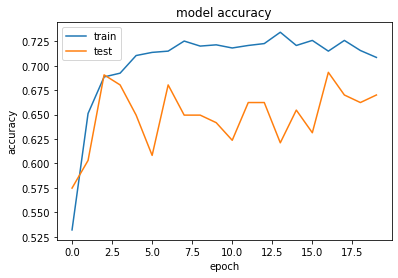

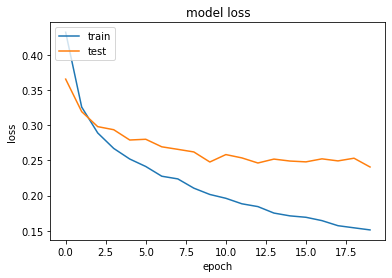

In [83]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()